# Basic sampler example: Linear Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

import tinyDA as tda

### Defining the true model and generating some data

In [2]:
b = 1 # intercept
m = 2 # slope
x = np.linspace(0,1) # support
y_pure = b + m*x # clean output

sigma = 0.2 # standard deviation of the noise
y = y_pure + np.random.normal(scale=sigma, size=x.shape[0]) # noisy data

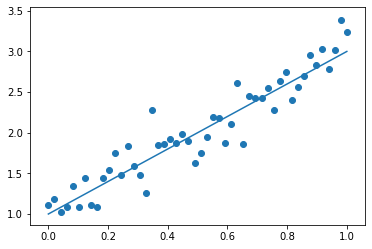

In [3]:
# plot it!
plt.plot(x, y_pure)
plt.scatter(x, y)
plt.show()

### Set up the statistical model

In [4]:
# set the prior
mean_prior = np.zeros(2)
cov_prior = np.eye(2)
my_prior = multivariate_normal(mean_prior, cov_prior)

# set the likelihood
cov_likelihood = sigma**2*np.eye(x.shape[0])
my_loglike = tda.LogLike(y, cov_likelihood)

In [5]:
# define a LinkFactory, that evaluates the model.
class MyLinkFactory(tda.LinkFactory):
    def evaluate_model(self, parameters):
        output = parameters[0] + parameters[1]*x
        qoi = None
        return output, qoi

In [6]:
# initialise the LinkFactory
my_link_factory = MyLinkFactory(my_prior, my_loglike)

### Set up the proposal

In [7]:
# random walk Metropolis
rwmh_cov = np.eye(2)
rmwh_scaling = 0.1
rwmh_adaptive = True
my_proposal = tda.GaussianRandomWalk(C=rwmh_cov, scaling=rmwh_scaling, adaptive=rwmh_adaptive)

# preconditioned Crank-Nicolson
#pcn_scaling = 0.1
#pcn_adaptive = True
#my_proposal = tda.CrankNicolson(scaling=pcn_scaling, adaptive=pcn_adaptive)

# adaptive Metropolis
#am_cov = np.eye(2)
#am_t0 = 2000
#am_sd = 1
#am_epsilon = 1e-6
#my_proposal = tda.AdaptiveMetropolis(C0=am_cov, t0=am_t0, sd=am_sd, epsilon=am_epsilon)

### Sample

In [8]:
my_chains = tda.sample(my_link_factory, my_proposal, iterations=12000, n_chains=2, force_sequential=True)

Running chain, α = 1.00:   0%|          | 0/12000 [00:00<?, ?it/s]/home/mikkel/.local/lib/python3.8/site-packages/tinyDA/proposal.py:223: RuntimeWarning: overflow encountered in exp
  return np.exp(proposal_link.posterior - previous_link.posterior)
Running chain, α = 0.21:   1%|          | 109/12000 [00:00<00:10, 1086.33it/s]

Sampling chain 1/2


Running chain, α = 0.21:   2%|▏         | 283/12000 [00:00<00:08, 1449.31it/s]

Sampling chain 2/2


Running chain, α = 0.26: 100%|██████████| 12000/12000 [00:12<00:00, 940.30it/s]


### Get some diagnostics

In [9]:
import arviz as az

In [10]:
idata = tda.to_inference_data(my_chains, burnin=2000)

/home/mikkel/.local/lib/python3.8/site-packages/arviz/data/inference_data.py:140: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


In [11]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta_0,1.015,0.057,0.903,1.118,0.002,0.001,793.0,1205.0,1.01
theta_1,2.012,0.100,1.824,2.199,0.004,0.003,647.0,890.0,1.01


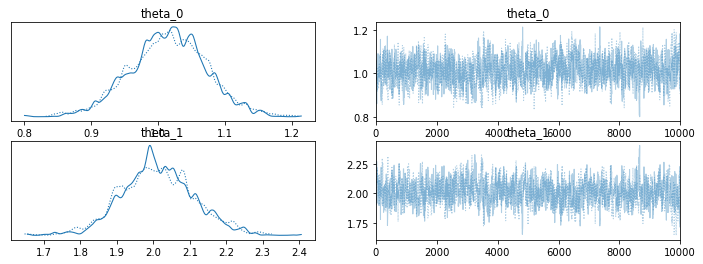

In [12]:
az.plot_trace(idata)
plt.show()